In [1]:
# Library import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from util.pairs_selection import *
from util.backtest import *
from util.bands import *

import warnings
warnings.filterwarnings(action='ignore')

import pickle
from pathlib import Path

In [2]:
from util.pf import round_trips as rt

In [3]:
trades_df = pd.read_csv('data/trades_df.csv', index_col=0)

In [4]:
trades_df

,entry,exit,position,ret,asset
0,2009-01-02,2009-01-22,1,-0.012802,"('금호석유', '금호석유우')"
1,2009-01-06,2009-01-07,-1,0.042899,"('유한양행', '유한양행우')"
2,2009-01-06,2009-02-04,1,-0.021272,"('삼성SDI', '삼성SDI우')"
3,2009-01-07,2009-01-12,1,0.152749,"('SK네트웍스', 'SK네트웍스우')"
4,2009-01-07,2009-01-23,1,0.075689,"('호텔신라', '호텔신라우')"
...,...,...,...,...,...
4243,2022-07-29,2022-08-09,-1,0.033254,"('CJ제일제당', 'CJ제일제당 우')"
4244,2022-08-01,2022-08-03,1,0.046412,"('SK네트웍스', 'SK네트웍스우')"
4245,2022-08-01,2022-08-17,1,0.012945,"('현대차', '현대차2우B')"
4246,2022-08-02,2022-08-11,-1,0.026225,"('LG전자', 'LG전자우')"


In [5]:
main_path = '/home/lululalamoon/CHO/chosta/data/k_stocks/daily/ohlcv'

In [6]:
initial_invest = 1_000_000_000
cash = 100_000_000
invest_money = (initial_invest-cash)/30

In [7]:
all_transactions = []

for i in range(len(trades_df.asset.unique())):
    trades_df_i = trades_df[trades_df.asset == trades_df.asset.unique()[i]]

    price_pairs = []
    stock_names = list(eval(trades_df.asset.unique()[i]))
    for j in stock_names:
        data = pd.read_csv(main_path + f'/{j}_ohlcv.csv', index_col=0, parse_dates=True)
        price = data.종가.rename(j)
        price_pairs.append(price)
        
    transactions_list = []
    asset_common = price_pairs[0].name
    asset_preferred = price_pairs[1].name
    for t in trades_df_i.index:
        entry = pd.to_datetime(trades_df_i.entry[t])
        exit = pd.to_datetime(trades_df_i.exit[t])

        position = trades_df_i.position[t]

        entry_price_common = price_pairs[0][entry]
        entry_price_preferred = price_pairs[1][entry]
        exit_price_common = price_pairs[0][exit]
        exit_price_preferred = price_pairs[1][exit]

        one_transaction = [[entry, -position*int(invest_money / entry_price_common), entry_price_common, asset_common],
                  [entry, position*int(invest_money / entry_price_preferred), entry_price_preferred, asset_preferred],
                  [exit, position*int(invest_money / entry_price_common), exit_price_common, asset_common],
                  [exit, -position*int(invest_money / entry_price_preferred), exit_price_preferred, asset_preferred]]
        one_transaction = pd.DataFrame(one_transaction, columns=['index','amount','price','symbol']).set_index('index')
        transactions_list.append(one_transaction)

    transactions = pd.concat(transactions_list)
    transactions['txn_dollars'] = transactions.amount*transactions.price*-1
    all_transactions.append(transactions)
    
all_transactions = pd.concat(all_transactions).sort_index()

In [8]:
avail_dates = price[all_transactions.index[0]:all_transactions.index[-1]].index.rename('index')

In [9]:
symbols = list(all_transactions.symbol.unique())
positions = pd.DataFrame(index=avail_dates)
positions['cash'] = cash
for symb in symbols:
    txn_ = -all_transactions[all_transactions['symbol']==symb].txn_dollars.rename(symb)
    positions = positions.join(txn_)

In [10]:
positions = positions.fillna(0)

In [11]:
returns = positions.sum(axis='columns').pct_change().fillna(0.0)

In [12]:
rts = rt.extract_round_trips(transactions=all_transactions,
                             portfolio_value=positions.sum(axis=1)/(returns + 1))

In [13]:
rts

,pnl,open_dt,close_dt,long,rt_returns,symbol,duration,returns
0,1068032.0,2009-05-07,2009-05-21,False,0.035655,CJ,14 days,0.004411
1,-1470582.0,2009-06-04,2009-07-09,True,-0.049045,CJ,35 days,0.010853
2,297201.0,2009-07-31,2009-08-24,False,0.009911,CJ,24 days,0.026700
3,1215720.0,2009-09-16,2009-09-29,True,0.040536,CJ,13 days,0.021523
4,1419708.0,2009-10-01,2009-10-13,False,0.047364,CJ,12 days,0.011899
...,...,...,...,...,...,...,...,...
8408,3139200.0,2021-11-30,2021-12-16,True,0.104651,호텔신라우,16 days,0.039933
8409,-81000.0,2022-01-06,2022-03-02,True,-0.002706,호텔신라우,55 days,-0.002999
8410,-2146500.0,2022-03-14,2022-04-06,False,-0.071622,호텔신라우,23 days,-0.005007
8411,-6375000.0,2022-05-13,2022-07-12,True,-0.212766,호텔신라우,60 days,-0.011627


In [14]:
rt.print_round_trip_stats(rts)

Summary stats,All trades,Short trades,Long trades
Total number of round_trips,8413.00,4205.00,4208.00
Percent profitable,0.60,0.59,0.61
Winning round_trips,5020.00,2474.00,2546.00
Losing round_trips,3273.00,1667.00,1606.00
Even round_trips,120.00,64.00,56.00


PnL stats,All trades,Short trades,Long trades
Total profit,$1720623459.00,$-243031345.00,$1963654804.00
Gross profit,$8230924221.00,$3756828438.00,$4474095783.00
Gross loss,$-6510300762.00,$-3999859783.00,$-2510440979.00
Profit factor,$1.26,$0.94,$1.78
Avg. trade net profit,$204519.61,$-57795.80,$466648.00
Avg. winning trade,$1639626.34,$1518524.03,$1757303.92
Avg. losing trade,$-1989092.81,$-2399435.98,$-1563163.75
Ratio Avg. Win:Avg. Loss,$0.82,$0.63,$1.12
Largest winning trade,$23309793.00,$13408382.00,$23309793.00
Largest losing trade,$-103003380.00,$-103003380.00,$-16144600.00


Duration stats,All trades,Short trades,Long trades
Avg duration,18 days 00:31:09.107333888,18 days 01:17:44.161712247,17 days 23:44:36.045627376
Median duration,15 days 00:00:00,15 days 00:00:00,15 days 00:00:00
Longest duration,118 days 00:00:00,118 days 00:00:00,118 days 00:00:00
Shortest duration,1 days 00:00:00,1 days 00:00:00,1 days 00:00:00


Return stats,All trades,Short trades,Long trades
Avg returns all round_trips,0.32%,0.28%,0.36%
Avg returns winning,1.80%,1.81%,1.79%
Avg returns losing,-2.05%,-2.16%,-1.93%
Median returns all round_trips,0.41%,0.42%,0.41%
Median returns winning,1.24%,1.28%,1.20%
Median returns losing,-1.12%,-1.13%,-1.11%
Largest winning trade,39.63%,39.63%,27.97%
Largest losing trade,-218.51%,-218.51%,-73.44%


Symbol stats,Avg returns all round_trips,Avg returns winning,Avg returns losing,Median returns all round_trips,Median returns winning,Median returns losing,Largest winning trade,Largest losing trade
symbol,,,,,,,,
CJ,0.66%,3.02%,-3.34%,0.52%,2.29%,-1.31%,18.92%,-24.63%
CJ우,0.28%,2.56%,-4.40%,0.43%,1.33%,-2.24%,17.53%,-39.11%
CJ제일제당,0.41%,1.86%,-2.23%,0.66%,1.33%,-1.78%,6.48%,-9.79%
CJ제일제당 우,0.71%,2.22%,-3.11%,0.63%,1.11%,-2.23%,19.49%,-9.39%
DB하이텍,0.15%,1.85%,-3.32%,0.64%,1.30%,-1.18%,10.43%,-31.27%
DB하이텍1우,0.56%,1.40%,-1.43%,0.58%,1.07%,-0.95%,4.58%,-4.01%
GS,0.46%,1.41%,-1.34%,0.49%,0.98%,-1.11%,4.92%,-4.62%
GS우,0.57%,1.21%,-1.33%,0.46%,0.93%,-0.75%,10.34%,-11.04%
JW중외제약,0.35%,2.22%,-1.95%,0.29%,1.45%,-0.91%,10.62%,-15.40%


In [15]:
def plot_prob_profit_trade(round_trips, ax=None):
    import scipy as sp
    """
    Plots a probability distribution for the event of making
    a profitable trade.

    Parameters
    ----------
    round_trips : pd.DataFrame
        DataFrame with one row per round trip trade.
        - See full explanation in round_trips.extract_round_trips
    ax : matplotlib.Axes, optional
        Axes upon which to plot.

    Returns
    -------
    ax : matplotlib.Axes
        The axes that were plotted on.
    """

    x = np.linspace(0, 1., 500)

    round_trips['profitable'] = round_trips.pnl > 0

    dist = sp.stats.beta(round_trips.profitable.sum(),
                         (~round_trips.profitable).sum())
    y = dist.pdf(x)
    lower_perc = dist.ppf(.025)
    upper_perc = dist.ppf(.975)

    lower_plot = dist.ppf(.001)
    upper_plot = dist.ppf(.999)

    if ax is None:
        ax = plt.subplot()

    ax.plot(x, y)
    ax.axvline(lower_perc, color='0.5')
    ax.axvline(upper_perc, color='0.5')

    ax.set_xlabel('Probability of making a profitable decision')
    ax.set_ylabel('Belief')
    ax.set_xlim(lower_plot, upper_plot)
    ax.set_ylim((0, y.max() + 1.))

    return ax

[Text(0.5, 0, 'Round-trip returns in %')]

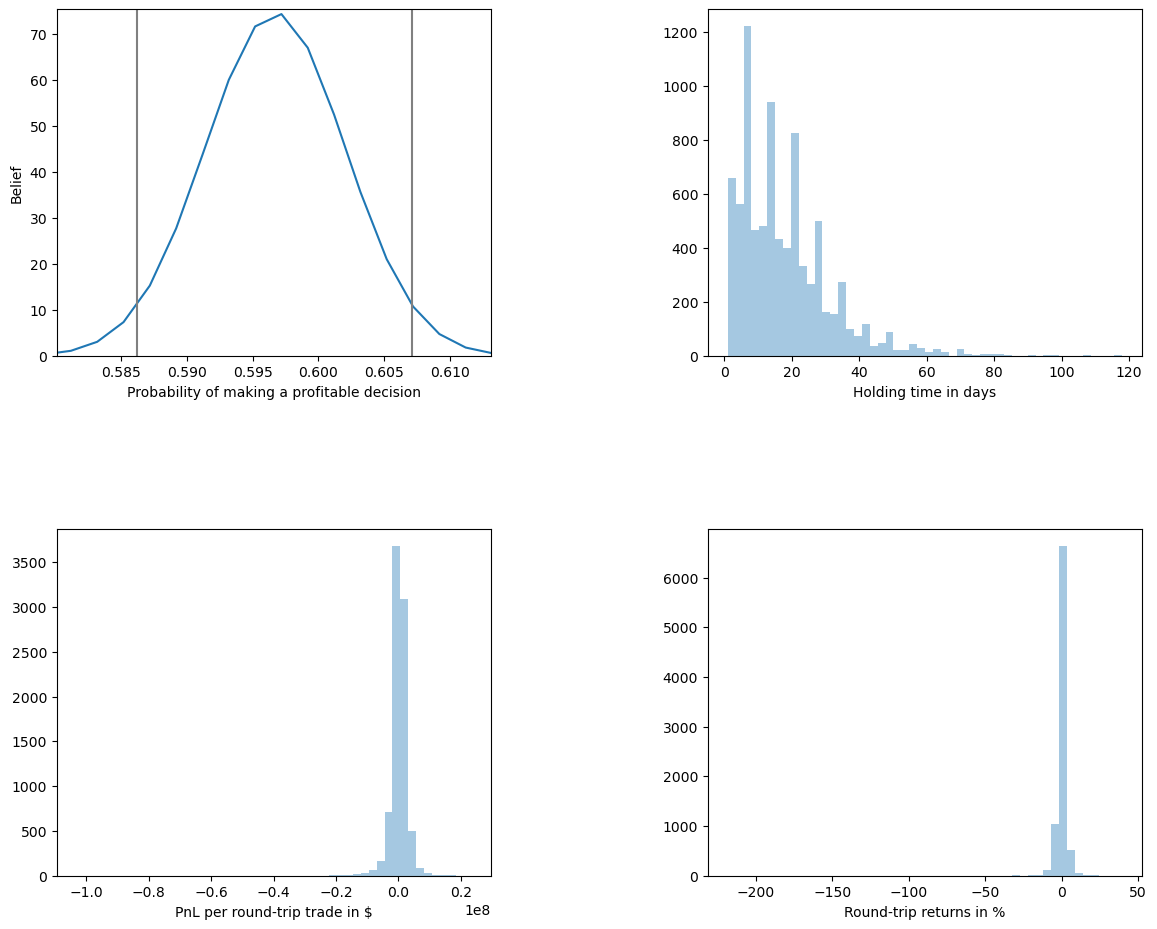

In [19]:
import seaborn as sns
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(14, 3 * 6))

gs = gridspec.GridSpec(3, 2, wspace=0.5, hspace=0.5)
ax_prob_profit_trade = plt.subplot(gs[1, 0])
ax_holding_time = plt.subplot(gs[1, 1])
ax_pnl_per_round_trip_dollars = plt.subplot(gs[2, 0])
ax_pnl_per_round_trip_pct = plt.subplot(gs[2, 1])

trades = rts.copy()
plot_prob_profit_trade(trades, ax=ax_prob_profit_trade)

trade_holding_times = [x.days for x in trades['duration']]
sns.distplot(trade_holding_times, kde=False, ax=ax_holding_time)
ax_holding_time.set(xlabel='Holding time in days')

sns.distplot(trades.pnl, kde=False, ax=ax_pnl_per_round_trip_dollars)
ax_pnl_per_round_trip_dollars.set(xlabel='PnL per round-trip trade in $')

sns.distplot(trades.returns.dropna() * 100, kde=False,
             ax=ax_pnl_per_round_trip_pct)
ax_pnl_per_round_trip_pct.set(
    xlabel='Round-trip returns in %')